#### Agents SDK Course

## Voice

The Agents SDK introduces several unique features, with one of the standout capabilities being voice functionality. The voice tutorial demonstrates how to build voice-enabled AI agents that can process spoken input, generate intelligent responses, and deliver those responses as natural-sounding speech.

> If you're working in Google Colab or another remote notebook service, you can install the following requirements for this notebook. If running locally, refer to the `uv` setup instructions in the [README](../README.md).

```
!pip install -qU \
    "matplotlib==3.10.1" \
    "openai==1.68.2" \
    "openai-agents[voice]==0.0.12" \
    "sounddevice==0.5.1"
```

## Working with Sound in Python

We'll be using the [`sounddevice` library](https://python-sounddevice.readthedocs.io/) to handle the audio input and streaming — which allows us to record audio into a numpy array, and play audio from a numpy array.

Before recording / playing audio with `sounddevice` we need to find the sample rate of our input and output devices. We can find our input / output device details using the `query_devices` function like so:

In [1]:
import sounddevice as sd

input_device = sd.query_devices(kind='input')
output_device = sd.query_devices(kind='output')

input_device, output_device

({'name': 'MacBook Pro Microphone',
  'index': 2,
  'hostapi': 0,
  'max_input_channels': 1,
  'max_output_channels': 0,
  'default_low_input_latency': 0.05235416666666667,
  'default_low_output_latency': 0.01,
  'default_high_input_latency': 0.0616875,
  'default_high_output_latency': 0.1,
  'default_samplerate': 48000.0},
 {'name': 'External Headphones',
  'index': 1,
  'hostapi': 0,
  'max_input_channels': 0,
  'max_output_channels': 2,
  'default_low_input_latency': 0.01,
  'default_low_output_latency': 0.0040416666666666665,
  'default_high_input_latency': 0.1,
  'default_high_output_latency': 0.013375,
  'default_samplerate': 48000.0})

We can find the sample rate for these devices via the `default_samplerate` field:

In [2]:
in_samplerate = sd.query_devices(kind='input')['default_samplerate']
out_samplerate = sd.query_devices(kind='output')['default_samplerate']

in_samplerate, out_samplerate

(48000.0, 48000.0)

We can record a stream of audio via `sd.InputStream`:

In [3]:
recorded_chunks = []

# start streaming from microphone until Enter is pressed
with sd.InputStream(
    samplerate=in_samplerate,
    channels=1,
    dtype='int16',
    callback=lambda indata, frames, time, status: recorded_chunks.append(indata.copy())
):
    input()

The `recorded_chunks` is a list of numpy arrays (the _chunks_) each containing audio data as a numpy array.

In [4]:
len(recorded_chunks)

482

Each of these chunks contains a `512` element vector, representing the audio for that chunk.

In [5]:
recorded_chunks[0].shape, recorded_chunks[1].shape, recorded_chunks[2].shape

((512, 1), (512, 1), (512, 1))

We `concatenate` these chunks to create a single audio file.

In [6]:
import numpy as np

audio_buffer = np.concatenate(recorded_chunks)
audio_buffer.shape

(246784, 1)

We can play the audio back like so:

In [7]:
sd.play(audio_buffer, samplerate=out_samplerate)

The `recorded_chunks` is a numpy array containing the recording we just made via `sd.InputStream` — we can visualize it like so:

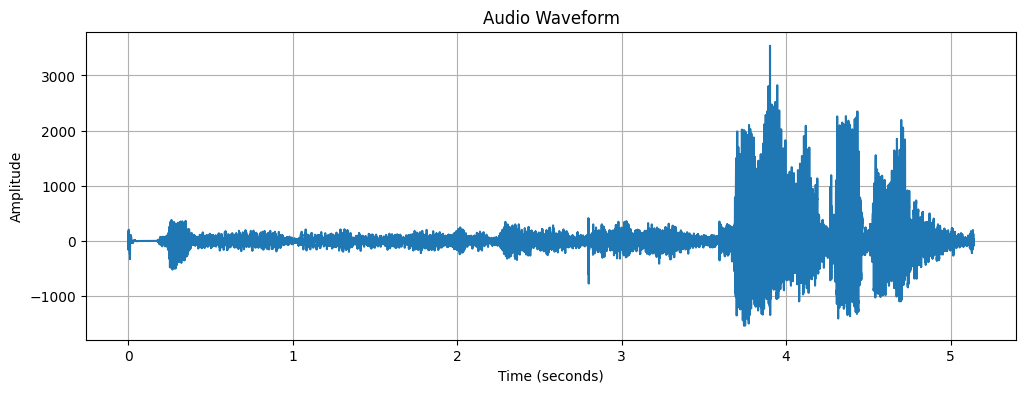

In [8]:
import matplotlib.pyplot as plt

# Create time axis
time = np.linspace(0, len(audio_buffer) / in_samplerate, num=len(audio_buffer))

# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(time, audio_buffer)
plt.title('Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Finally, before we can pass this data to a voice pipeline in Agents SDK, we must transform it into an `AudioInput` object like so:

In [9]:
from agents.voice import AudioInput

audio_input = AudioInput(
    buffer=audio_buffer,
    frame_rate=in_samplerate,
    channels=audio_buffer.shape[1],  # 1 channel == mono, 2 channels == stereo
)
audio_input

AudioInput(buffer=array([[ -70],
       [-133],
       [-154],
       ...,
       [   6],
       [   9],
       [  29]], shape=(246784, 1), dtype=int16), frame_rate=48000.0, sample_width=2, channels=1)

## Setting up the `VoicePipeline`

We've seen how to work with audio in Python. Now it's time for us to jump into working with audio with the Agents SDK.

In [10]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass.getpass("OpenAI API Key: ")

In [12]:
from agents import Agent

agent = Agent(
    name="Assistant",
    instructions=(
        "Repeat the user's question back to them, and then answer it. Note that the user is "
        "speaking to you via a voice interface, although you are reading and writing text to "
        "respond. Nonetheless, ensure that your written response is easily translatable to voice."
    ),
    model="gpt-4.1-nano"
)

We will use the `VoicePipeline` from Agents SDK, which requires two parameters.

### Workflow Parameter

The `workflow` which is our `agent` from above transformed into a voice workflow via the `SingleAgentVoiceWorkflow` object.

In [13]:
from agents.voice import SingleAgentVoiceWorkflow

workflow = SingleAgentVoiceWorkflow(agent)

### Config Parameter

The `config` is where we pass our `VoicePipelineConfig`. Inside this config we provide a `TTSModelSettings` object within which we provide instructions on how the voice should be.

In [14]:
from agents.voice import TTSModelSettings, VoicePipelineConfig

# Define custom TTS model settings with the desired instructions
custom_tts_settings = TTSModelSettings(
    instructions=(
        "Personality: upbeat, friendly, persuasive guide.\n"
        "Tone: Friendly, clear, and reassuring, creating a calm atmosphere and making "
        "the listener feel confident and comfortable.\n"
        "Pronunciation: Clear, articulate, and steady, ensuring each instruction is "
        "easily understood while maintaining a natural, conversational flow.\n"
        "Tempo: Speak relatively fast, include brief pauses and after before questions.\n"
        "Emotion: Warm and supportive, conveying empathy and care, ensuring the listener "
        "feels guided and safe throughout the journey."
    )
)

voice_pipeline_config = VoicePipelineConfig(tts_settings=custom_tts_settings)

In [15]:
from agents.voice import VoicePipeline

pipeline = VoicePipeline(workflow=workflow, config=voice_pipeline_config)

Now we can provide our `audio_input` to our pipeline to receive an audio output stream. This is handled asynchronousely so we must `await` the pipeline and capture the audio streamed events, which we find via the `type="voice_stream_event_audio"`.

In [ ]:
result = await pipeline.run(audio_input=audio_input)

response_chunks = []

async for event in result.stream():
    if event.type == "voice_stream_event_audio":
        response_chunks.append(event.data)

# concatenate all of the chunks into a single audio buffer
response_audio_buffer = np.concatenate(response_chunks, axis=0)

# openai sample rate is 24000
openai_sample_rate = 24_000

# play the response
sd.play(response_audio_buffer, samplerate=openai_sample_rate)
sd.wait()  # this prevents the cell from finishing before the full audio is played

Great! We have our spoken response from our LLM. Now we can wrap this up into a more conversational interface. We will make it so that we can click the `Enter` key to speak, and press `"q"` once we're finished.

In [17]:
async def voice_assistant_optimized():
    while True:
        # check for input to either provide voice or exit
        cmd = input("Press Enter to speak (or type 'q' to exit): ")
        if cmd.lower() == "q":
            print("Exiting...")
            break
        print("Listening...")
        recorded_chunks = []

         # start streaming from microphone until Enter is pressed
        with sd.InputStream(
            samplerate=in_samplerate,
            channels=1,
            dtype='int16',
            callback=lambda indata, frames, time, status: recorded_chunks.append(indata.copy())
        ):
            input()

        # concatenate chunks into single buffer
        recording = np.concatenate(recorded_chunks, axis=0)

        # input the buffer and await the result
        audio_input = AudioInput(buffer=recording)

        result = await pipeline.run(audio_input)

         # transfer the streamed result into chunks of audio
        response_chunks = []
        async for event in result.stream():
            if event.type == "voice_stream_event_audio":
                response_chunks.append(event.data)

        response_audio_buffer = np.concatenate(response_chunks, axis=0)

        # play response
        print("Assistant is responding...")
        sd.play(response_audio_buffer, samplerate=openai_sample_rate)
        sd.wait()
        print("---")

# run the voice assistant
await voice_assistant_optimized()

Listening...
Assistant is responding...
---
Exiting...


---